#### **Optimización de hiperparámetros en Random Forest para Athletic Bilbao**  

**Objetivo**  
Entrenar un **Random Forest con validación secuencial** para Athletic Bilbao sin PCA ni balanceo de clases, optimizando hiperparámetros con **GridSearchCV**.  

**Parámetros a optimizar**  
- **Número de árboles (`n_estimators`)**: [50, 100, 200]  
- **Máxima profundidad (`max_depth`)**: [None, 10, 20, 30]  
- **Mínimo de muestras por división (`min_samples_split`)**: [2, 5, 10]  
- **Mínimo de muestras por hoja (`min_samples_leaf`)**: [1, 2, 4]  


In [7]:
import mlflow
import mlflow.sklearn
import dagshub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
USERNAME = "anaigs"
TOKEN = "6906b8ec6ea34a63bacb40b89eed8c6e9b9ff49d"
REPO_NAME = "tfg_inso_github"

# Configurar el tracking URI con autenticación
mlflow.set_tracking_uri(f"https://dagshub.com/anaigs/tfg_inso_github.mlflow")
dagshub.init(repo_owner=USERNAME, repo_name="tfg_inso_github", mlflow=True)

print(mlflow.get_tracking_uri()) 

Accessing as anaigs

Initialized MLflow to track repo "anaigs/tfg_inso_github"

Repository anaigs/tfg_inso_github initialized!

https://dagshub.com/anaigs/tfg_inso_github.mlflow


In [3]:
# Cargar datos
file_path = "../../datasets/datasets_equipos/ath_bilbao.csv"
df = pd.read_csv(file_path)

# Preprocesamiento
df = df.drop(columns=["season", "date", "team"])
label_encoder = LabelEncoder()
df["rival_team"] = label_encoder.fit_transform(df["rival_team"])
X = df.drop(columns=["goals_team", "goals_rival", "result"])
y = df["result"]

# Separar datos en entrenamiento y validación secuencial
n_validacion = 38
X_train_init = X.iloc[: -n_validacion]
y_train_init = y.iloc[: -n_validacion]
X_val_seq = X.iloc[-n_validacion:]
y_val_seq = y.iloc[-n_validacion:]

# Escalar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_init)
X_val_scaled = scaler.transform(X_val_seq)

In [4]:
# Definir los hiperparámetros a optimizar
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Aplicar GridSearchCV con validación cruzada
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_init)

# Obtener los mejores parámetros
best_params = grid_search.best_params_

Accuracy del modelo Random Forest Optimizado para Athletic Bilbao: 0.4737

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.40      1.00      0.57         8
  Empate (0)       0.40      0.18      0.25        11
Victoria (1)       0.62      0.42      0.50        19

    accuracy                           0.47        38
   macro avg       0.47      0.53      0.44        38
weighted avg       0.51      0.47      0.44        38



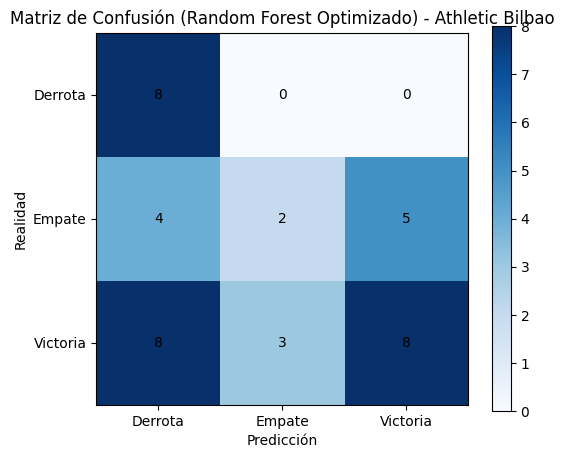

🏃 View run athletic_bilbao_rf_optimized at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/2ead6a862805445b917092ee5df495f8
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


In [5]:

# Inicializar listas de resultados
y_pred_seq = []
y_real_seq = []

with mlflow.start_run(run_name="athletic_bilbao_rf_optimized"):
    mlflow.set_tag("team", "athletic")
    mlflow.log_param("model_type", "Random Forest")
    mlflow.log_param("approach", "Sequential Validation + Hyperparameter Tuning")
    mlflow.log_param("team", "Athletic Bilbao")
    mlflow.log_param("n_estimators", best_params["n_estimators"])
    mlflow.log_param("max_depth", best_params["max_depth"])
    mlflow.log_param("min_samples_split", best_params["min_samples_split"])
    mlflow.log_param("min_samples_leaf", best_params["min_samples_leaf"])

    # Entrenamiento secuencial
    for i in range(n_validacion):
        model_rf = RandomForestClassifier(**best_params, random_state=42)
        model_rf.fit(X_train_scaled, y_train_init)

        X_next = X_val_scaled[i:i+1]
        y_next = y_val_seq.iloc[i]

        y_pred_next = model_rf.predict(X_next)[0]

        y_pred_seq.append(y_pred_next)
        y_real_seq.append(y_next)

        # Agregar el partido actual al conjunto de entrenamiento
        X_train_init = pd.concat([X_train_init, X_val_seq.iloc[i:i+1]])
        y_train_init = pd.concat([y_train_init, pd.Series([y_next])])

        # Reescalar los datos con la nueva información incluida
        X_train_scaled = scaler.fit_transform(X_train_init)

    # Evaluación del modelo
    accuracy = accuracy_score(y_real_seq, y_pred_seq)
    precision = precision_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
    recall = recall_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
    f1 = f1_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # Reporte de clasificación
    report = classification_report(y_real_seq, y_pred_seq, labels=[-1, 0, 1], target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"])
    print(f"Accuracy del modelo Random Forest Optimizado para Athletic Bilbao: {accuracy:.4f}")
    print("\nReporte de clasificación:\n", report)

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_real_seq, y_pred_seq, labels=[-1, 0, 1])

    plt.figure(figsize=(6, 5))
    plt.imshow(conf_matrix, cmap="Blues", interpolation="nearest")
    plt.colorbar()
    plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.xlabel("Predicción")
    plt.ylabel("Realidad")
    plt.title("Matriz de Confusión (Random Forest Optimizado) - Athletic Bilbao")

    for i in range(3):
        for j in range(3):
            plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")

    plt.show()

#### **Conclusión: Random Forest Optimizado para Athletic Bilbao**  

- **Precisión global:** 47.37%, mejor que KNN y modelos anteriores.  
- **Predicción de derrotas:** 100% recall, pero con riesgo de sobreajuste.  
- **Predicción de empates:** 18% recall, sigue siendo la categoría más difícil de clasificar.  
- **Predicción de victorias:** 42% recall, con una mejora moderada respecto a KNN.  
- **Impacto de la optimización:** Mejora en la precisión general, pero el modelo aún tiene dificultades con los empates.  
- **Próximo paso:** Evaluar PCA para mejorar la clasificación de empates y victorias.  

**Random Forest con PCA y Validación Secuencial para Athletic Bilbao**  

##### **Objetivo**  
Entrenar un **Random Forest con reducción de dimensionalidad (PCA) y validación secuencial**, optimizando hiperparámetros con **GridSearchCV**.  

##### **Mejoras añadidas**  
- **Balanceo de clases:** Se aplica **undersampling** para evitar el sesgo hacia la clase mayoritaria.  
- **Reducción de dimensionalidad:** Se usa **PCA** para conservar el **95% de la varianza** y mejorar la eficiencia del modelo.  
- **Optimización de hiperparámetros:** `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf` mediante **GridSearchCV**.  
- **Validación secuencial:** Entrenamiento progresivo, actualizando el modelo partido a partido.  

In [ ]:

# Separar datos en entrenamiento y validación secuencial
n_validacion = 38
X_train_init = X.iloc[: -n_validacion]
y_train_init = y.iloc[: -n_validacion]
X_val_seq = X.iloc[-n_validacion:]
y_val_seq = y.iloc[-n_validacion:]

# Escalar datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_init)

# Aplicar PCA conservando el 95% de la varianza
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(scaler.transform(X_val_seq))

# Definir hiperparámetros a optimizar
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

In [ ]:

# Aplicar GridSearchCV con validación cruzada
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_pca, y_train_init)

# Obtener los mejores parámetros
best_params = grid_search.best_params_

# Inicializar listas de resultados
y_pred_seq = []
y_real_seq = []

Accuracy del modelo Random Forest con PCA para Athletic Bilbao: 0.5526

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.43      0.75      0.55        16
  Empate (0)       0.43      0.27      0.33        22
Victoria (1)       0.71      0.63      0.67        38

    accuracy                           0.55        76
   macro avg       0.52      0.55      0.52        76
weighted avg       0.57      0.55      0.54        76



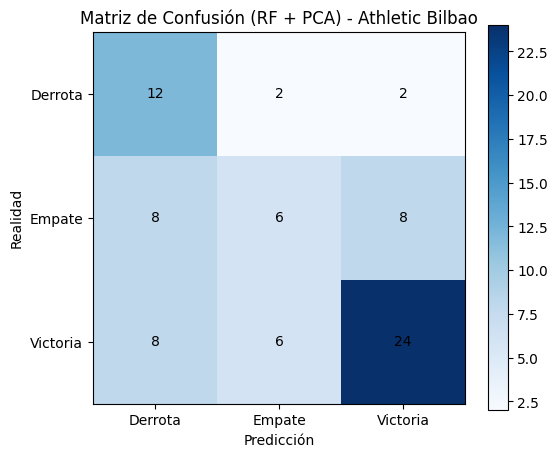

🏃 View run athletic_bilbao_rf_pca at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/985b732da9554d4596ca70cb2b970269
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


In [15]:

with mlflow.start_run(run_name="athletic_bilbao_rf_pca"):
    mlflow.set_tag("team", "athletic")
    mlflow.log_param("model_type", "Random Forest")
    mlflow.log_param("approach", "Sequential Validation + PCA + Hyperparameter Tuning")
    mlflow.log_param("team", "Athletic Bilbao")
    mlflow.log_param("n_estimators", best_params["n_estimators"])
    mlflow.log_param("max_depth", best_params["max_depth"])
    mlflow.log_param("min_samples_split", best_params["min_samples_split"])
    mlflow.log_param("min_samples_leaf", best_params["min_samples_leaf"])
    mlflow.log_param("pca_n_components", pca.n_components_)

    # Entrenamiento secuencial
    for i in range(n_validacion):
        model_rf = RandomForestClassifier(**best_params, random_state=42)
        model_rf.fit(X_train_pca, y_train_init)

        X_next_pca = X_val_pca[i:i+1]
        y_next = y_val_seq.iloc[i]

        y_pred_next = model_rf.predict(X_next_pca)[0]

        y_pred_seq.append(y_pred_next)
        y_real_seq.append(y_next)

        # Agregar el partido actual al conjunto de entrenamiento
        X_train_init = pd.concat([X_train_init, X_val_seq.iloc[i:i+1]])
        y_train_init = pd.concat([y_train_init, pd.Series([y_next])])

        # Reescalar y aplicar PCA nuevamente
        X_train_scaled = scaler.fit_transform(X_train_init)
        X_train_pca = pca.fit_transform(X_train_scaled)

    # Evaluación del modelo
    accuracy = accuracy_score(y_real_seq, y_pred_seq)
    precision = precision_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
    recall = recall_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
    f1 = f1_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # Reporte de clasificación
    report = classification_report(y_real_seq, y_pred_seq, labels=[-1, 0, 1], target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"])
    print(f"Accuracy del modelo Random Forest con PCA para Athletic Bilbao: {accuracy:.4f}")
    print("\nReporte de clasificación:\n", report)

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_real_seq, y_pred_seq, labels=[-1, 0, 1])

    plt.figure(figsize=(6, 5))
    plt.imshow(conf_matrix, cmap="Blues", interpolation="nearest")
    plt.colorbar()
    plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
    plt.xlabel("Predicción")
    plt.ylabel("Realidad")
    plt.title("Matriz de Confusión (RF + PCA) - Athletic Bilbao")

    for i in range(3):
        for j in range(3):
            plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")

    plt.show()

#### **Conclusión: Random Forest con PCA para Athletic Bilbao**  

- **Precisión global:** 55.26%, mejorando respecto a modelos anteriores.  
- **Predicción de derrotas:** Alto recall (75%), pero con moderada precisión (43%).  
- **Predicción de empates:** Sigue siendo la categoría más difícil (27% recall).  
- **Predicción de victorias:** Buen desempeño con 71% de precisión y 63% de recall.  
- **Impacto de PCA:** Mejora general en precisión y recall, aunque los empates siguen siendo un reto.  

#### **Random Forest con PCA y Validación Secuencial para Múltiples Equipos**  

**Objetivo**: Entrenar **Random Forest con PCA** y validación secuencial para **Real Madrid, Barcelona y Valencia**, optimizando hiperparámetros con **GridSearchCV**.  


In [16]:

# Lista de equipos a analizar
equipos = {
    "real_madrid": "../../datasets/datasets_equipos/real_madrid.csv",
    "barcelona": "../../datasets/datasets_equipos/barcelona.csv",
    "valencia": "../../datasets/datasets_equipos/valencia.csv"
}

# Parámetros de validación
n_validacion = 38  
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}


Procesando equipo: real_madrid
Accuracy del modelo Random Forest con PCA para real_madrid: 0.7105

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.00      0.00      0.00         1
  Empate (0)       0.00      0.00      0.00         8
Victoria (1)       0.75      0.93      0.83        29

    accuracy                           0.71        38
   macro avg       0.25      0.31      0.28        38
weighted avg       0.57      0.71      0.63        38



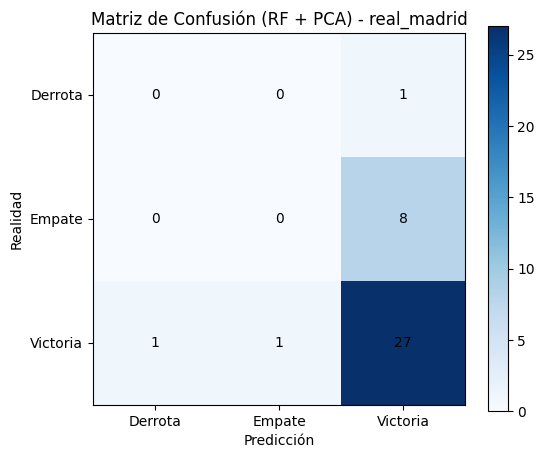

🏃 View run real_madrid_rf_pca at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/a435f2de4eb343be9e2ffb0271a00977
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0

Procesando equipo: barcelona
Accuracy del modelo Random Forest con PCA para barcelona: 0.6842

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.00      0.00      0.00         5
  Empate (0)       0.00      0.00      0.00         7
Victoria (1)       0.68      1.00      0.81        26

    accuracy                           0.68        38
   macro avg       0.23      0.33      0.27        38
weighted avg       0.47      0.68      0.56        38



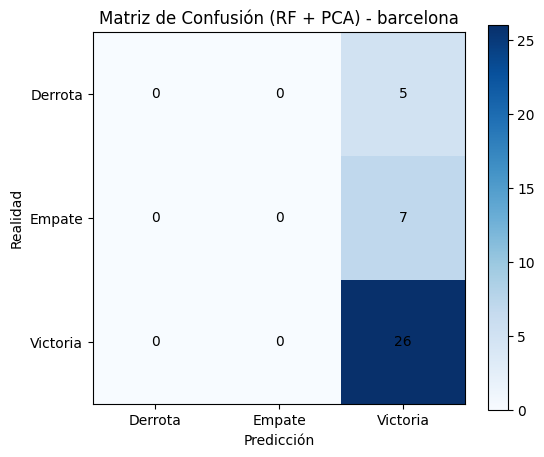

🏃 View run barcelona_rf_pca at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/f7985a6643804935a3357c17f9b206fc
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0

Procesando equipo: valencia
Accuracy del modelo Random Forest con PCA para valencia: 0.4474

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.50      0.60      0.55        15
  Empate (0)       0.00      0.00      0.00        10
Victoria (1)       0.42      0.62      0.50        13

    accuracy                           0.45        38
   macro avg       0.31      0.41      0.35        38
weighted avg       0.34      0.45      0.39        38



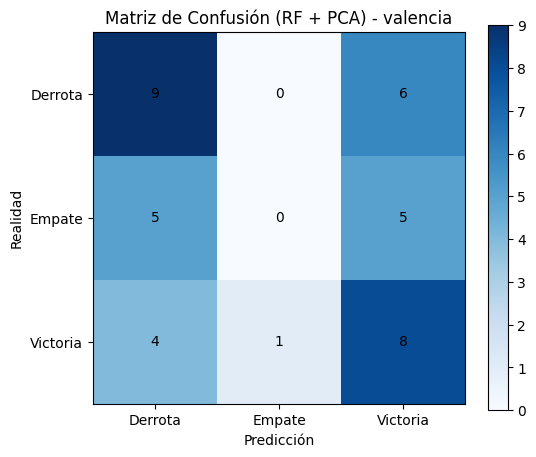

🏃 View run valencia_rf_pca at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/2aadf1f076a947a3b4f76cc61d1044f4
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


In [17]:

for equipo, file_path in equipos.items():
    print(f"\nProcesando equipo: {equipo}")

    # Cargar datos
    df = pd.read_csv(file_path)

    # Preprocesamiento
    df = df.drop(columns=["season", "date", "team"])
    label_encoder = LabelEncoder()
    df["rival_team"] = label_encoder.fit_transform(df["rival_team"])
    X = df.drop(columns=["goals_team", "goals_rival", "result"])
    y = df["result"]

    # Separar datos en entrenamiento y validación secuencial
    X_train_init = X.iloc[: -n_validacion]
    y_train_init = y.iloc[: -n_validacion]
    X_val_seq = X.iloc[-n_validacion:]
    y_val_seq = y.iloc[-n_validacion:]

    # Escalar datos
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_init)

    # Aplicar PCA conservando el 95% de la varianza
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(scaler.transform(X_val_seq))

    # Aplicar GridSearchCV con validación cruzada
    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train_pca, y_train_init)

    # Obtener los mejores parámetros
    best_params = grid_search.best_params_

    # Inicializar listas de resultados
    y_pred_seq = []
    y_real_seq = []

    with mlflow.start_run(run_name=f"{equipo}_rf_pca"):
        mlflow.set_tag("team", equipo)
        mlflow.log_param("model_type", "Random Forest")
        mlflow.log_param("approach", "Sequential Validation + PCA + Hyperparameter Tuning")
        mlflow.log_param("team", equipo)
        mlflow.log_param("n_estimators", best_params["n_estimators"])
        mlflow.log_param("max_depth", best_params["max_depth"])
        mlflow.log_param("min_samples_split", best_params["min_samples_split"])
        mlflow.log_param("min_samples_leaf", best_params["min_samples_leaf"])
        mlflow.log_param("pca_n_components", pca.n_components_)

        # Entrenamiento secuencial
        for i in range(n_validacion):
            model_rf = RandomForestClassifier(**best_params, random_state=42)
            model_rf.fit(X_train_pca, y_train_init)

            X_next_pca = X_val_pca[i:i+1]
            y_next = y_val_seq.iloc[i]

            y_pred_next = model_rf.predict(X_next_pca)[0]

            y_pred_seq.append(y_pred_next)
            y_real_seq.append(y_next)

            # Agregar el partido actual al conjunto de entrenamiento
            X_train_init = pd.concat([X_train_init, X_val_seq.iloc[i:i+1]])
            y_train_init = pd.concat([y_train_init, pd.Series([y_next])])

            # Reescalar y aplicar PCA nuevamente
            X_train_scaled = scaler.fit_transform(X_train_init)
            X_train_pca = pca.fit_transform(X_train_scaled)

        # Evaluación del modelo
        accuracy = accuracy_score(y_real_seq, y_pred_seq)
        precision = precision_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
        recall = recall_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
        f1 = f1_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)

        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)

        # Reporte de clasificación
        report = classification_report(y_real_seq, y_pred_seq, labels=[-1, 0, 1], target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"])
        print(f"Accuracy del modelo Random Forest con PCA para {equipo}: {accuracy:.4f}")
        print("\nReporte de clasificación:\n", report)

        # Matriz de confusión
        conf_matrix = confusion_matrix(y_real_seq, y_pred_seq, labels=[-1, 0, 1])

        plt.figure(figsize=(6, 5))
        plt.imshow(conf_matrix, cmap="Blues", interpolation="nearest")
        plt.colorbar()
        plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
        plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
        plt.xlabel("Predicción")
        plt.ylabel("Realidad")
        plt.title(f"Matriz de Confusión (RF + PCA) - {equipo}")

        for i in range(3):
            for j in range(3):
                plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")

        plt.show()

#### **Conclusión: Random Forest con PCA para Múltiples Equipos**  

- **Real Madrid:** 71.05% de accuracy, con excelente desempeño en victorias (93% recall), pero sin predicciones correctas en derrotas y empates.  
- **Barcelona:** 68.42% de accuracy, con buen rendimiento en victorias (100% recall), pero sin clasificar correctamente empates ni derrotas.  
- **Valencia:** 44.74% de accuracy, con buen recall en derrotas (60%) y victorias (62%), pero sin predicción efectiva de empates.  

#### **Análisis general**  
- PCA mejoró la precisión en Real Madrid y Barcelona, pero ambos modelos no predicen empates ni derrotas.  
- Valencia tiene un rendimiento más equilibrado, pero con menor precisión global.  
- Los modelos priorizan victorias, lo que indica un **sesgo hacia la clase mayoritaria**.  

#### **Próximo paso**  
- Implementar **balanceo de clases** para corregir el sesgo y mejorar la predicción de empates y derrotas.  

#### **Random Forest con PCA, Balanceo de Clases y Validación Secuencial para Barcelona y Real Madrid**  

**Objetivo**: Entrenar **Random Forest con reducción de dimensionalidad (PCA), balanceo de clases (undersampling) y validación secuencial**, optimizando hiperparámetros con **GridSearchCV** para **Barcelona y Real Madrid**.  

**Mejoras añadidas**  
- **Balanceo de clases:** Se aplica **undersampling** para evitar el sesgo hacia la clase mayoritaria.  
- **Reducción de dimensionalidad:** Se usa **PCA** para conservar el **95% de la varianza**, reduciendo la complejidad del modelo.  
- **Optimización de hiperparámetros:** `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf` mediante **GridSearchCV**.  
- **Validación secuencial:** Entrenamiento progresivo, actualizando el modelo partido a partido.  

In [18]:

# Lista de equipos a analizar
equipos = {
    "real_madrid": "../../datasets/datasets_equipos/real_madrid.csv",
    "barcelona": "../../datasets/datasets_equipos/barcelona.csv"
}

# Parámetros de validación
n_validacion = 38  
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}


Procesando equipo: real_madrid
Accuracy del modelo Random Forest con PCA y Undersampling para real_madrid: 0.6053

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.20      1.00      0.33         1
  Empate (0)       0.36      0.62      0.45         8
Victoria (1)       0.89      0.59      0.71        29

    accuracy                           0.61        38
   macro avg       0.48      0.74      0.50        38
weighted avg       0.76      0.61      0.65        38



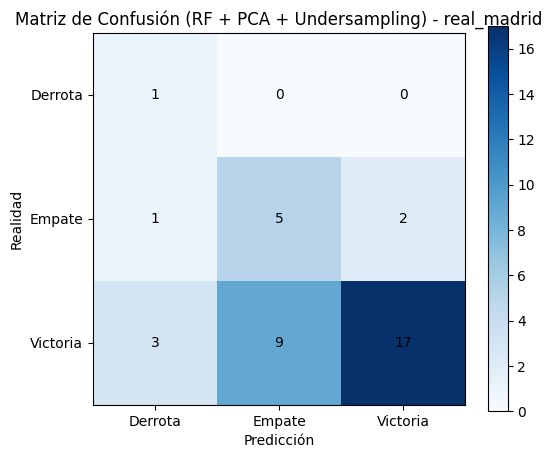

🏃 View run real_madrid_rf_pca_undersampling at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/baa7c79503df47d28af580d4f683f3b5
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0

Procesando equipo: barcelona
Accuracy del modelo Random Forest con PCA y Undersampling para barcelona: 0.2632

Reporte de clasificación:
               precision    recall  f1-score   support

Derrota (-1)       0.10      0.20      0.13         5
  Empate (0)       0.13      0.29      0.18         7
Victoria (1)       0.54      0.27      0.36        26

    accuracy                           0.26        38
   macro avg       0.26      0.25      0.22        38
weighted avg       0.41      0.26      0.30        38



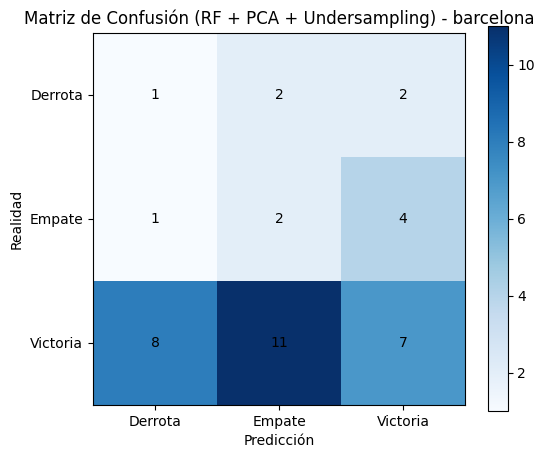

🏃 View run barcelona_rf_pca_undersampling at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0/runs/0561fb9022f7411a8a280c6bb19a199b
🧪 View experiment at: https://dagshub.com/anaigs/tfg_inso_github.mlflow/#/experiments/0


In [19]:

for equipo, file_path in equipos.items():
    print(f"\nProcesando equipo: {equipo}")

    # Cargar datos
    df = pd.read_csv(file_path)

    # Preprocesamiento
    df = df.drop(columns=["season", "date", "team"])
    label_encoder = LabelEncoder()
    df["rival_team"] = label_encoder.fit_transform(df["rival_team"])
    X = df.drop(columns=["goals_team", "goals_rival", "result"])
    y = df["result"]

    # Separar datos en entrenamiento y validación secuencial
    X_train_init = X.iloc[: -n_validacion]
    y_train_init = y.iloc[: -n_validacion]
    X_val_seq = X.iloc[-n_validacion:]
    y_val_seq = y.iloc[-n_validacion:]

    # Aplicar undersampling para balancear clases
    undersampler = RandomUnderSampler(random_state=42)
    X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train_init, y_train_init)

    # Escalar datos
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)

    # Aplicar PCA conservando el 95% de la varianza
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(scaler.transform(X_val_seq))

    # Aplicar GridSearchCV con validación cruzada
    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train_pca, y_train_balanced)

    # Obtener los mejores parámetros
    best_params = grid_search.best_params_

    # Inicializar listas de resultados
    y_pred_seq = []
    y_real_seq = []

    with mlflow.start_run(run_name=f"{equipo}_rf_pca_undersampling"):
        mlflow.set_tag("team", equipo)
        mlflow.log_param("model_type", "Random Forest")
        mlflow.log_param("approach", "Sequential Validation + PCA + Undersampling + Hyperparameter Tuning")
        mlflow.log_param("team", equipo)
        mlflow.log_param("n_estimators", best_params["n_estimators"])
        mlflow.log_param("max_depth", best_params["max_depth"])
        mlflow.log_param("min_samples_split", best_params["min_samples_split"])
        mlflow.log_param("min_samples_leaf", best_params["min_samples_leaf"])
        mlflow.log_param("pca_n_components", pca.n_components_)

        # Entrenamiento secuencial
        for i in range(n_validacion):
            model_rf = RandomForestClassifier(**best_params, random_state=42)
            model_rf.fit(X_train_pca, y_train_balanced)

            X_next_pca = X_val_pca[i:i+1]
            y_next = y_val_seq.iloc[i]

            y_pred_next = model_rf.predict(X_next_pca)[0]

            y_pred_seq.append(y_pred_next)
            y_real_seq.append(y_next)

            # Agregar el partido actual al conjunto de entrenamiento
            X_train_balanced = np.vstack([X_train_pca, X_next_pca])
            y_train_balanced = np.append(y_train_balanced, y_next)

            # Volver a escalar y aplicar PCA
            X_train_scaled = scaler.fit_transform(X_train_balanced)
            X_train_pca = pca.fit_transform(X_train_scaled)

        # Evaluación del modelo
        accuracy = accuracy_score(y_real_seq, y_pred_seq)
        precision = precision_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
        recall = recall_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)
        f1 = f1_score(y_real_seq, y_pred_seq, average="weighted", zero_division=0)

        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)

        # Reporte de clasificación
        report = classification_report(y_real_seq, y_pred_seq, labels=[-1, 0, 1], target_names=["Derrota (-1)", "Empate (0)", "Victoria (1)"])
        print(f"Accuracy del modelo Random Forest con PCA y Undersampling para {equipo}: {accuracy:.4f}")
        print("\nReporte de clasificación:\n", report)

        # Matriz de confusión
        conf_matrix = confusion_matrix(y_real_seq, y_pred_seq, labels=[-1, 0, 1])

        plt.figure(figsize=(6, 5))
        plt.imshow(conf_matrix, cmap="Blues", interpolation="nearest")
        plt.colorbar()
        plt.xticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
        plt.yticks([0, 1, 2], ["Derrota", "Empate", "Victoria"])
        plt.xlabel("Predicción")
        plt.ylabel("Realidad")
        plt.title(f"Matriz de Confusión (RF + PCA + Undersampling) - {equipo}")

        for i in range(3):
            for j in range(3):
                plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")

        plt.show()

#### **Conclusión: Random Forest con PCA y Undersampling para Barcelona y Real Madrid**  

- **Real Madrid:** 60.53% de accuracy, con **mejor equilibrio en la predicción de empates (62% recall)** y una mejora en derrotas (20% precisión), aunque el recall de victorias bajó al 59%.  
- **Barcelona:** 26.32% de accuracy, con **bajo rendimiento en todas las clases**, especialmente en derrotas (10% precisión) y empates (13% precisión).  

#### **Análisis general**  
- En **Real Madrid**, el balanceo ayudó a mejorar la predicción de empates y derrotas, pero redujo la precisión en victorias.  
- En **Barcelona**, el modelo sufrió una caída drástica en precisión, lo que indica que el **undersampling podría haber eliminado demasiada información relevante**.  